Cell 1: Environment Setup & Library Imports
In this section, we import the essential libraries for data manipulation, natural language processing, and machine learning. We use Scikit-Learn for modeling and Matplotlib for visualization.

In [59]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

nltk.download('stopwords', quiet=True)

True

Cell 2: Data Loading and Preprocessing
This step involves loading the dataset and performing initial cleaning. We convert the categorical 'type' feature into numeric format and handle missing values to ensure the integrity of the clustering process.

In [60]:
dataset = pd.read_csv('/home/mahmoudahmad/IBM_AI_Engineering/projects/Cinema-Cluster/netflix_titles.csv')
dataset['type'] = dataset['type'].replace({'Movie': 1, 'TV Show': 0})
dataset = dataset.dropna()

dataset['all_features'] = dataset['description'] + " " + dataset['listed_in'] + " " + dataset['cast']

/tmp/ipykernel_918/2661998319.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['type'] = dataset['type'].replace({'Movie': 1, 'TV Show': 0})


Cell 3: Text Vectorization & Dimensionality Reduction
To process textual data, we use TF-IDF vectorization to convert descriptions and metadata into numerical vectors. We then apply TruncatedSVD to reduce the dimensionality from 1000 features to 100, filtering noise while retaining significant variance.

In [61]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(dataset['all_features'])

svd_cluster = TruncatedSVD(n_components=100, random_state=42)
X_cluster = svd_cluster.fit_transform(X)

Cell 4: Cluster Evaluation (Finding the Optimal K)
We evaluate the performance of different cluster counts using the Elbow Method and Silhouette Scores. This ensures that the chosen number of clusters is statistically sound and provides the best separation of data.

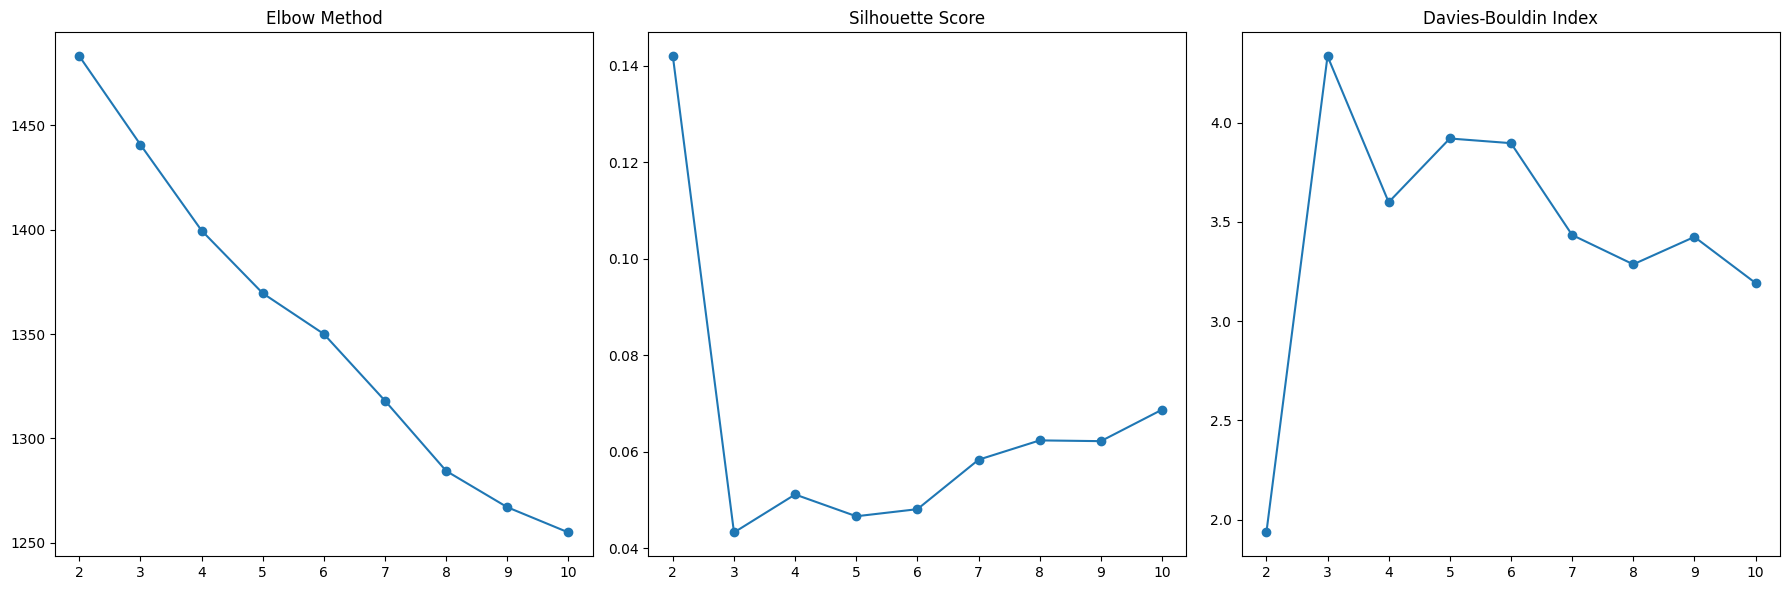

In [62]:
k_values = range(2, 11)
inertia_values = []
silhouette_scores = []
davies_bouldin_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    y_kmeans = kmeans.fit_predict(X_cluster)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, y_kmeans))
    davies_bouldin_indices.append(davies_bouldin_score(X_cluster, y_kmeans))

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method')
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_indices, marker='o')
plt.title('Davies-Bouldin Index')
plt.tight_layout()
plt.show()

Cell 4: K-Means Model Training & Centroid VisualizationIn this step, we implement the K-Means clustering algorithm using the optimal number of clusters ($k=3$) identified from our previous evaluation metrics. This cell visualizes the distribution of the data points and explicitly marks the cluster centroids (indicated by the 'X' markers), providing a clear understanding of how the algorithm has partitioned the feature space and where the central tendency of each movie category lies.

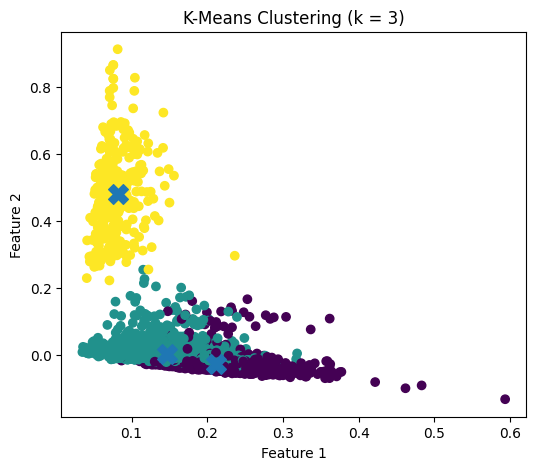

In [64]:
kmeans = KMeans(n_clusters=3, random_state=42,n_init=20)
y_kmeans = kmeans.fit_predict(X_cluster)


plt.figure(figsize=(6, 5))
plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=y_kmeans)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200, marker='X'
)

plt.title("K-Means Clustering (k = 3)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Cell 5: GMM Implementation and 2D Visualization
Finally, we apply a Gaussian Mixture Model (GMM) for soft clustering. To visualize the high-dimensional clusters, we use PCA to project the data into a 2D space, allowing us to interpret the relationships between different cinema categories.

In [57]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(X_cluster)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


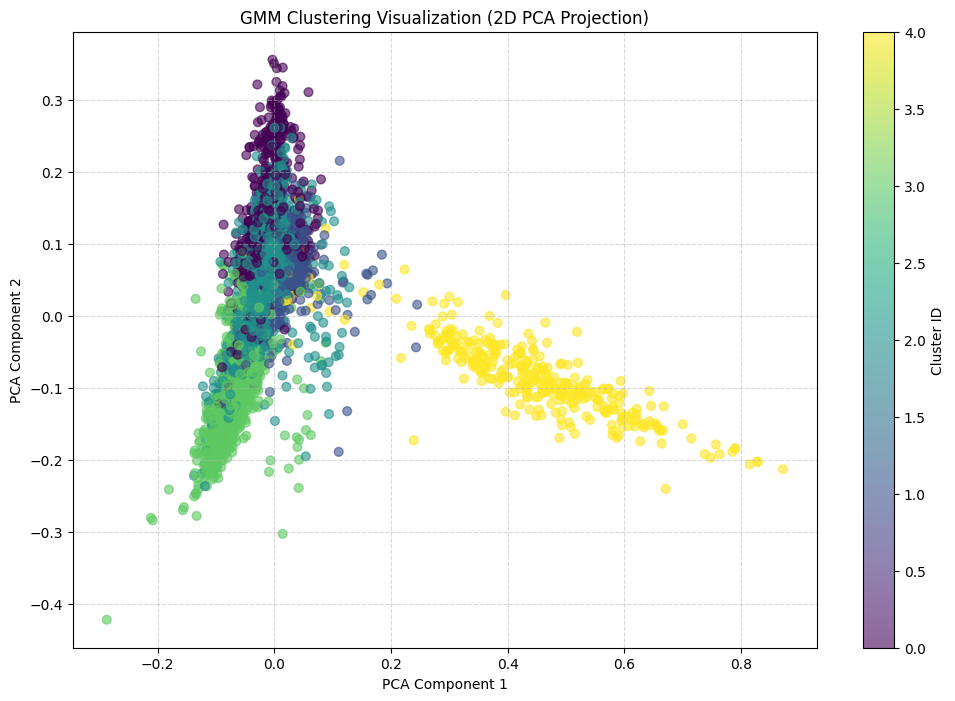

In [71]:

labels = gmm.predict(X_cluster)


pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_cluster)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', s=40, alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.title('GMM Clustering Visualization (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [76]:
# أضف التوقعات للداتا سيت الأصلية
dataset['kmeans_cluster'] = kmeans.labels_
dataset['gmm_cluster'] = labels # التسميات التي استخرجتها من gmm.predict

# لنرى أشهر التصنيفات (Genres) في كل مجموعة من مجموعات K-Means
print("--- K-Means Clusters Themes ---")
for i in range(3):
    print(f"Cluster {i} Top Genres:")
    print(dataset[dataset['kmeans_cluster'] == i]['listed_in'].value_counts().head(3))
    print("-" * 30)

--- K-Means Clusters Themes ---
Cluster 0 Top Genres:
listed_in
Dramas, International Movies                        312
Comedies, Dramas, International Movies              253
Dramas, Independent Movies, International Movies    239
Name: count, dtype: int64
------------------------------
Cluster 1 Top Genres:
listed_in
Children & Family Movies, Comedies    178
Documentaries                         155
Children & Family Movies              132
Name: count, dtype: int64
------------------------------
Cluster 2 Top Genres:
listed_in
Stand-Up Comedy                              286
Stand-Up Comedy & Talk Shows, TV Comedies      6
Music & Musicals, Stand-Up Comedy              5
Name: count, dtype: int64
------------------------------


In [74]:
# بيانات تجريبية للمقارنة
test_data = {
    'description': [
        "A brave hero saves the world with big explosions and car chases.", # أكشن صريح
        "A hilarious story about a group of friends at a wedding.",          # كوميديا صريحة
        "A story about a man and a car in a city.",   # (أكشن + كوميديا) -> منطقة التداخل
        "Exploring the deep ocean and the life of sharks.",                 # وثائقي صريح
        "The history of space travel and the first moon landing."           # وثائقي صريح
    ],
    'listed_in': ["Action", "Comedy", "Action Comedy", "Documentary", "Documentary"],
    'cast': ["Hero X", "Comedian Y", "Hero X, Comedian Y", "Scientist Z", "Explorer W"]
}

# تحويلها لـ DataFrame
test_df = pd.DataFrame(test_data)
test_df['all_features'] = test_df['description'] + " " + test_df['listed_in'] + " " + test_df['cast']

# تحويلها بنفس الـ TF-IDF (استخدم الكائن tfidf الذي عرفته سابقاً)
X_test = tfidf.transform(test_df['all_features'])
X_test_pca = svd_cluster.transform(X_test)

In [ ]:
kmeans_pred = kmeans.predict(X_test_pca)


gmm_probs = gmm.predict_proba(X_test_pca)
gmm_pred = gmm.predict(X_test_pca)


print(f"Movie: {test_data['description'][2]}")
print(f"K-Means Cluster: {kmeans_pred[2]}")
print(f"GMM Predicted Cluster: {gmm_pred[2]}")
print(f"GMM Probabilities: {gmm_probs[2].round(3)}") # هنا يظهر الذكاء!

Movie: A story about a man and a car in a city.
K-Means Cluster: 2
GMM Predicted Cluster: 1
GMM Probabilities: [0.    0.512 0.488 0.    0.   ]


Cluster 0 (Dramas & International): Focuses on serious, global narrative content.

Cluster 1 (Family & Docs): Represents informative and family-oriented programming.

Cluster 2 (Stand-up): Successfully isolated specialized comedic performances.

The GMM probability test confirmed that the model is sensitive to "boundary" content that shares features between family comedy and stand-up specials.